<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-up-the-environment" data-toc-modified-id="Setting-up-the-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting-up the environment</a></span></li><li><span><a href="#Selenium-config" data-toc-modified-id="Selenium-config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Selenium config</a></span></li><li><span><a href="#Google-Images-config" data-toc-modified-id="Google-Images-config-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Google Images config</a></span></li><li><span><a href="#Scraping-the-image-url" data-toc-modified-id="Scraping-the-image-url-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scraping the image url</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

## Setting-up the environment

In [57]:
# Commo, package for interaction with windows and system
import os
import sys

# Packages and subpackages to get, open an url and get exception when open it
import urllib.request
from urllib.request import Request, urlopen
from urllib.error import HTTPError, URLError

# To scroll dynamically on website
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains

# For time management
import time
from time import sleep

First, we configure the folder where all the photos will be store.

In [58]:
# Configuration
IMAGES_PATH = "download/"
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

## Selenium config

We need to set-up the Selenium driver for scraping. The webdrimer `chromedriver` can be found on the Internet and have to be put in the parent directory.

With this setting, the web browser will be hidden during scraping (`headless` option).

In [60]:
class Driver():

    def __init__(self):

        self.path_to_web_driver = "../chromedriver"
        self.options = webdriver.ChromeOptions()
        self.options.add_argument("headless")
        self.driver = webdriver.Chrome(
            executable_path=self.path_to_web_driver,
            chrome_options=self.options)

    def get(self, url):
        self.driver.get(url)


The first function is to prepare the Google Drive website in order to get enough image as requested. As the site works dynamically, we need to scroll down until enough images are displayed. At this time, we extract the meta-data of the image based on their XPath.

The function returns a lsit of XPath which can be read and opened with JSON.

## Google Images config

In [61]:
def prepare_google_image(word, number):
    
    # Number_of_scrolls * 400 images will be opened in the browser
    number_of_scrolls = int(number / 400 + 1)
    
    # Create the image downloaded folder : replace space with undescorces
    word_ = word.replace(" ", "_")
    image_path = os.path.join(IMAGES_PATH, word_)
    
    if not os.path.exists(image_path):
        os.makedirs(image_path)
        print("{} folder created.".format(image_path))
    
    # The google image generated url with the requested word to search
    url = "https://www.google.co.in/search?q=" + word + "&source=lnms&tbm=isch"
    
    # We initialize the driver for scraping and get the url data
    driver = Driver()
    driver.get(url)
    
    # Prepare Google Page
    for _ in range(number_of_scrolls):
        for __ in range(10):
            # Multiple scrolls needed to show all 400 images
            driver.driver.execute_script("window.scrollBy(0, 1000000)")
            time.sleep(0.2)
        # to load next 400 images
        time.sleep(2.5)
        try:
            driver.driver.find_element_by_xpath(
                "//input[@value='Show more results']").click()
            time.sleep(2.5)
        except Exception as e:
            print("Less images found:" + str(e))
            break
    
    img_list = driver.driver.find_elements_by_xpath(
         '//div[contains(@class,"rg_meta")]')
    
    return img_list

## Scraping the image url

When all the XPath have been collected, we simply need to browse the list and download the image thanks to its url which we found in the JSON file.

In order to browser all the list and not be stopped, I put two exceptions from `urllib` which captures undesired exceptions.

In [62]:
def get_images(word, number):
    
    img_list = prepare_google_image(word, number)
    
    word_ = word.replace(" ", "_")
    image_path = os.path.join(IMAGES_PATH, word_)
    
    for i in range(min(number, len(img_list))):
        img = img_list[i]
        img_name = word_ + str(i)
        img_url = json.loads(img.get_attribute('innerHTML'))["ou"]
        img_type = json.loads(img.get_attribute('innerHTML'))["ity"]
        img_path = os.path.join(image_path, img_name + "." + img_type)
        
        try:
        
            if img_type in ["jpg", "jpeg"]:
                urllib.request.urlretrieve(img_url, img_path)
 
        except HTTPError:
            pass
        
        except URLError:
            pass

        sys.stdout.write("\rDownloading: {}/{}".format(i, number))
        sys.stdout.flush()

In [63]:
get_images("Messi", 100)

Less images found:Message: no such element: Unable to locate element: {"method":"xpath","selector":"//input[@value='Show more results']"}
  (Session info: headless chrome=68.0.3440.106)
  (Driver info: chromedriver=2.36.540470 (e522d04694c7ebea4ba8821272dbef4f9b818c91),platform=Windows NT 10.0.16299 x86_64)

Downloading: 99/100

In [65]:
get_images("Cristiano Ronaldo", 100)

download/Cristiano_Ronaldo folder created.
Less images found:Message: no such element: Unable to locate element: {"method":"xpath","selector":"//input[@value='Show more results']"}
  (Session info: headless chrome=68.0.3440.106)
  (Driver info: chromedriver=2.36.540470 (e522d04694c7ebea4ba8821272dbef4f9b818c91),platform=Windows NT 10.0.16299 x86_64)

Downloading: 99/100

## Results

In [70]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

As all our images have been downloaded, we can check some examples from them. Firstly, I generated a dictionary where the keys are the names of the folders in the `download` directory (in my case, football players) and the value are the absolute path to all the pictures inside this directory.

In [74]:
def import_images(path=IMAGES_PATH):
    dict_path = dict()
    
    classes = os.listdir(path)
    for classe in classes:
        if classe != ".ipynb_checkpoints":
            dict_path[classe] = []
            class_dir = os.path.join(path, classe)
            class_dir_ = os.path.abspath(class_dir)
            images = os.listdir(class_dir)
            for image in images:
                img_path = os.path.join(class_dir_, image)
                if img_path.endswith(".jpg"):
                    dict_path[classe].append(img_path)
            
    return dict_path

In [75]:
img_dict = import_images()

Class: Cristiano_Ronaldo


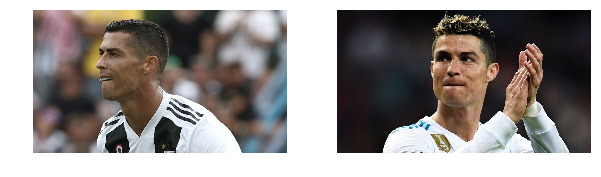

Class: Griezmann


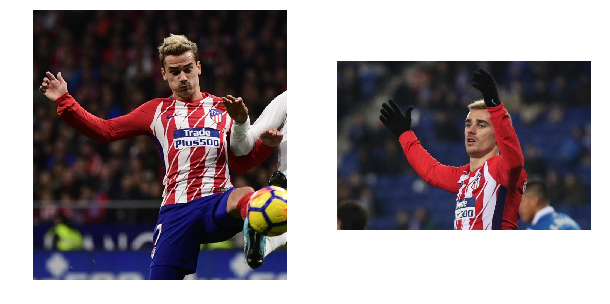

Class: Lloris


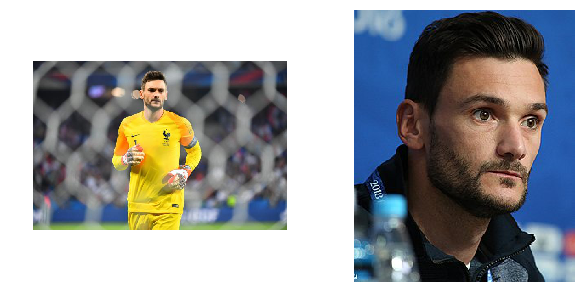

Class: Mbappé


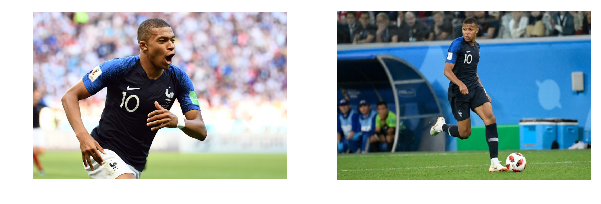

Class: Messi


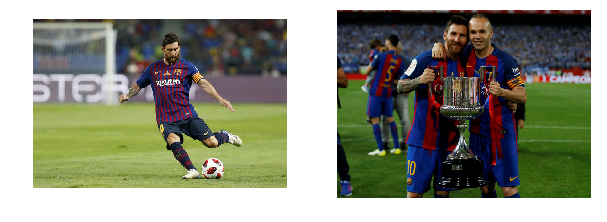

Class: Pogba


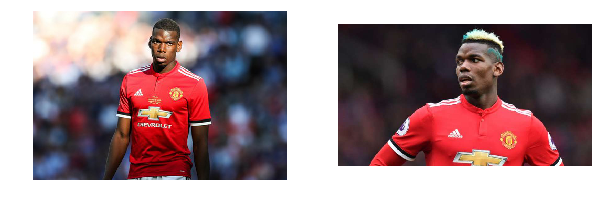

In [77]:
for classe in img_dict.keys():
    print("Class:", classe)
    plt.figure(figsize=(10,5))
    
    img_path_0 = img_dict[classe][0]
    img_path_1 = img_dict[classe][1]
    
    img0 = mpimg.imread(img_path_0)[:, :, :]
    img1 = mpimg.imread(img_path_1)[:, :, :]
    
    plt.subplot(121)
    plt.imshow(img0)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(img1)
    plt.axis("off")
    plt.show()